# Class

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class Net(nn.Module):
    def __init__(self):
        #继承父类的所有属性
        super(Net,self).__init__()
        # 1 input image channel, 6 output channels, 3 x 3 square convolution 
        # kernel
        self.conv1 = nn.Conv2d(1,6,3)
        self.conv2 = nn.Conv2d(6,16,3)
        # an affine operation: y = Wx +b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)# 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self,x):
        # Max pooling over a (2,2) window
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        #view函数将张量x变形成一维的向量形式，总特征数并不改变，为接下来的全连接作准备。
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    # 计算张量x的总特征量
    def num_flat_features(self,x):
        size = x.size()[1:] 
        # since pytorch only accept batch input which means several pictures,we only need the last three dim.
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
print(net)        

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [3]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 3, 3])


In [4]:
input = torch.randn(1,1,32,32)
out = net(input)
print(out)

tensor([[ 0.1488,  0.0642,  0.0246, -0.1001,  0.1351,  0.0419,  0.1143, -0.0460,
         -0.0221, -0.0650]], grad_fn=<AddmmBackward>)


In [5]:
net.zero_grad()
out.backward(torch.randn(1,10))

In [6]:
# compute the loss function
output = net(input)
target = torch.randn(10)
target = target.view(1,-1)
criterion = nn.MSELoss()

loss = criterion(output,target)
print(loss)

tensor(1.3961, grad_fn=<MseLossBackward>)


In [7]:
# backprop
#zeroes the gradient buffers of all parameters
net.zero_grad()
print("conv1.bias.grad before backward")
print(net.conv1.bias.grad)

loss.backward()
print("conv1.bias.grad after backward")
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([ 0.0022,  0.0063, -0.0043, -0.0145, -0.0010, -0.0002])


In [8]:
# update the weights
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)
# utilize the package
import torch.optim as optim
# create your optimizer
optimizer = optim.SGD(net.parameters(),lr = 0.01)
# in the training loop:
optimizer.zero_grad()
output = net(input)
loss = criterion(output,target)
loss.backward()
optimizer.step()

# Lab

In [9]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
)

In [11]:
# set the parameters
batch_size = 8
epoch = 2
lr = 0.01

In [12]:
train_data = datasets.MNIST(root = './data',train = True,download = True,transform =transform)
test_data = datasets.MNIST(root = './data',train = False,download = True,transform =transform)

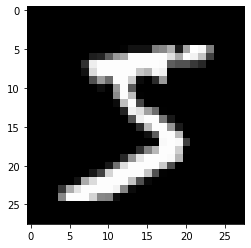

5


In [13]:
# 60000,28,28
#print(train_data.data.size())
import matplotlib.pyplot as plt

for i in range(1):
    plt.imshow(train_data.data[i].numpy(),cmap='gray')
    plt.show()
    print(train_data.targets[i].item())

In [14]:
# dataloader
trainloader = torch.utils.data.DataLoader(train_data,batch_size = batch_size,shuffle = True, num_workers = 2)
testloader = torch.utils.data.DataLoader(test_data,batch_size = batch_size,shuffle = False, num_workers = 2)

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # Max pooling over a (2,2) window
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(-1,3*3*64 )
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
net = Net()    
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [16]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [17]:
from torchsummary import summary
model = Net()
if torch.cuda.is_available():
    model.cuda()
summary(model, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
            Conv2d-2           [-1, 32, 20, 20]          25,632
            Conv2d-3             [-1, 64, 6, 6]          51,264
            Linear-4                  [-1, 256]         147,712
            Linear-5                   [-1, 10]           2,570
Total params: 228,010
Trainable params: 228,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.26
Params size (MB): 0.87
Estimated Total Size (MB): 1.13
----------------------------------------------------------------


In [18]:
net.cuda()
# loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr = lr)
for e in range(epoch):
    for j, data in enumerate(trainloader):
        inputs,labels = data
        train_x = inputs.cuda()
        train_y = labels.cuda()        
        optimizer.zero_grad()
        outputs = net(train_x)
        loss = criterion(outputs,train_y)
        loss.backward()
        optimizer.step() 
print("Finish training")

Finish training


In [19]:
PATH = './mnist_net.pth'
torch.save(net.state_dict(),PATH)

In [20]:
correct = 0 
total = 0
with torch.no_grad():
    for data in testloader:
        images,labels = data
        test_x = images.cuda()
        test_y = labels.cuda()
        outputs = net(test_x)
        _,predicted = torch.max(outputs.data,1)
        pred_y = predicted.cpu()
        total += labels.size(0)
        correct += (pred_y == labels).sum().item()
        accuracy = correct/total
print("Accuracy: {}".format(accuracy))       

Accuracy: 0.9689


In [21]:
# prepare to count predictions for each class
classes = ('0', '1', '2', '3','4', '5', '6', '7', '8', '9')
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for data in testloader:
        images,labels = data
        test_x = images.cuda()
        test_y = labels.cuda()
        outputs = net(test_x)
        _,predicted = torch.max(outputs.data,1)
        pred_y = predicted.cpu()
        # collect the correct predictions for each class
        for label, prediction in zip(labels,pred_y):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] +=1
for classtype, correct_count in correct_pred.items():
    accuracy = correct_count/total_pred[classtype]
    print("Accuracy for class{} is: {:.3f}".format(classtype,accuracy))  

Accuracy for class0 is: 0.988
Accuracy for class1 is: 0.989
Accuracy for class2 is: 0.966
Accuracy for class3 is: 0.948
Accuracy for class4 is: 0.963
Accuracy for class5 is: 0.978
Accuracy for class6 is: 0.982
Accuracy for class7 is: 0.970
Accuracy for class8 is: 0.940
Accuracy for class9 is: 0.955


The classification performance is well.

# Questions

(1) yes, they can be used for unsupervised clustering and data dimension reduction because we just need to train the parameters. The unsupervised learning in convolutional neural networks is employed via autoencoders.

(2)
a. Neural networks are flexible and can be used for both regression and classification problems. Any data which can be made numeric can be used in the model, as neural network is a mathematical model with approximation functions.

b. Neural networks are good to model with nonlinear data with large number of inputs; for example, images. It is reliable in an approach of tasks involving many features. It works by splitting the problem of classification into a layered network of simpler elements.

c. Neural networks can be trained with any number of inputs and layers.

d. Once trained, the predictions are pretty fast.

e. Neural networks work best with more data points.

(3)
a. Neural networks are black boxes, meaning we cannot know how much each independent variable is influencing the dependent variables.

b. It is computationally very expensive and time consuming to train with traditional CPUs.

c. Neural networks depend a lot on training data. This leads to the problem of over-fitting and generalization. The mode relies more on the training data and may be tuned to the data.

(4) If the data is big enough it can make neural network a good candidate.